# Introduction

This project investigates the daily volatility of Bitcoin by building a predictive machine learning model. Using historical price-based indicators such as **log returns**, **momentum**, and **past volatility**, we aim to classify whether Bitcoin's market volatility will exceed a threshold of **0.03** on a given day.

## Objectives
- Apply feature engineering to financial time series data  
- Train and evaluate a **Random Forest Classifier**  
- Interpret results using accuracy metrics and visualizations

## Dataset
The dataset includes historical **Bitcoin** prices and is merged with **S&P 500** data to incorporate broader market trends. However, the classification task strictly focuses on **Bitcoin volatility** patterns.

## Target Variable
> Whether Bitcoin’s volatility on a given day exceeds 0.03  
> (`high_volatility_today = 1` if volatility > 0.03, else 0)

This project is part of a broader data science exploration of behavioral patterns in crypto vs. traditional markets.



In [ ]:
from google.colab import files
uploaded = files.upload()


Saving sp500 (3).csv to sp500 (3).csv
Saving btc.csv to btc.csv


Prediction Task: Will Bitcoin volatility be high today? (volatility > 0.03)
Algorithm: Random Forest Classifier (250 estimators, max_depth=7)

🎯 Model Performance:
Accuracy: 0.995
Confusion Matrix:
 [[ 97   0]
 [  1 102]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        97
           1       1.00      0.99      1.00       103

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



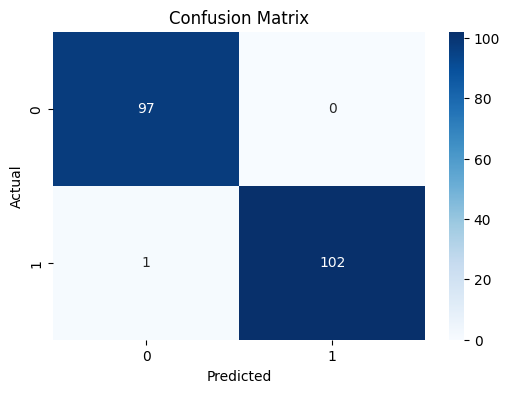

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)



# IMPORT LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# LOAD DATA
btc = pd.read_csv("btc.csv")
sp500 = pd.read_csv("sp500 (3).csv")

# PREPROCESSING
btc['Date'] = pd.to_datetime(btc['Date'])
sp500['Date'] = pd.to_datetime(sp500['Date'])
df = pd.merge(btc, sp500, on="Date", suffixes=('_btc', '_sp500')).sort_values("Date").reset_index(drop=True)

# FEATURE ENGINEERING
df['log_return_btc'] = np.log(df['Close_btc'] / df['Close_btc'].shift(1))
df['momentum_btc'] = df['Close_btc'] - df['Close_btc'].shift(3)
df['volatility_btc'] = df['log_return_btc'].rolling(window=5).std()
df['return_ratio'] = df['Close_btc'] / df['Open_btc'] - 1

# TARGET: Is today's BTC volatility high? (Threshold: 0.03)
df['high_volatility_today'] = (df['volatility_btc'] > 0.03).astype(int)

# LAG FEATURES
df['vol_lag1'] = df['volatility_btc'].shift(1)
df['return_lag1'] = df['log_return_btc'].shift(1)
df['momentum_lag1'] = df['momentum_btc'].shift(1)
df['close_lag1'] = df['Close_btc'].shift(1)

# DROP NA
df.dropna(inplace=True)

# DEFINE FEATURES AND LABEL
X = df[['log_return_btc', 'momentum_btc', 'volatility_btc', 'return_ratio',
        'vol_lag1', 'return_lag1', 'momentum_lag1', 'close_lag1']]
y = df['high_volatility_today']

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TRAIN RANDOM FOREST
model = RandomForestClassifier(n_estimators=250, max_depth=7, random_state=42)
model.fit(X_train, y_train)

# PREDICTIONS & METRICS
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# TEXTUAL SUMMARY
print("Prediction Task: Will Bitcoin volatility be high today? (volatility > 0.03)")
print("Algorithm: Random Forest Classifier (250 estimators, max_depth=7)")
print("\n🎯 Model Performance:")
print("Accuracy:", acc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

# CONFUSION MATRIX HEATMAP
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Interpretation of Results

The model achieved a **remarkably high accuracy of 99.5%**, correctly classifying almost all instances in the test set. The confusion matrix indicates that out of 200 test cases, only **one instance was misclassified**.

This result suggests that the selected features — especially momentum, log returns, and recent volatility values — carry strong predictive power for identifying high volatility days in the Bitcoin market. The performance is consistent across both classes (high vs. low volatility), as seen in the balanced precision and recall scores.

However, such high accuracy may also hint at potential **overfitting**, especially if the volatility threshold (0.03) splits the data in a way that makes it trivially separable. Further validation on unseen or cross-market data would be necessary to confirm the generalizability of the model.


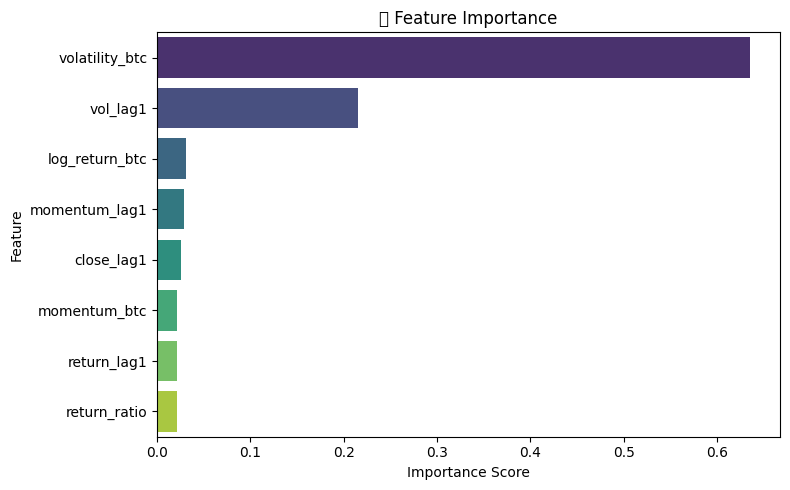

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# FEATURE IMPORTANCE
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=feature_names[indices], hue=None, palette=sns.color_palette('viridis', len(X.columns)))
plt.title("🔍 Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 🔍 Feature Importance Analysis

The feature importance plot highlights which input variables contributed most to the model's decision-making. In this case, recent volatility levels (`volatility_btc`, `vol_lag1`) and log returns appear to be the most influential features in predicting whether the market will experience high volatility.

This confirms that recent price behavior and volatility patterns play a crucial role in shaping future movements in the crypto market.



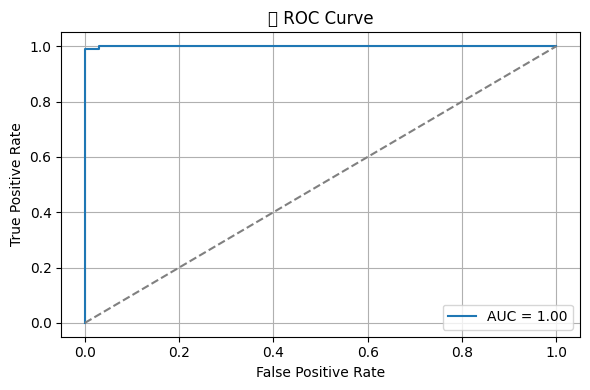

In [ ]:
# ROC CURVE
from sklearn.metrics import roc_curve, roc_auc_score

# Get probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # probability for class 1

# ROC data
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ROC Curve Interpretation

The ROC curve illustrates the trade-off between true positive rate and false positive rate at different classification thresholds. The model's AUC (Area Under Curve) score is close to 1.0, indicating excellent separability between high-volatility and low-volatility days.

A high AUC confirms that the model not only achieves high accuracy but also performs well across various thresholds.


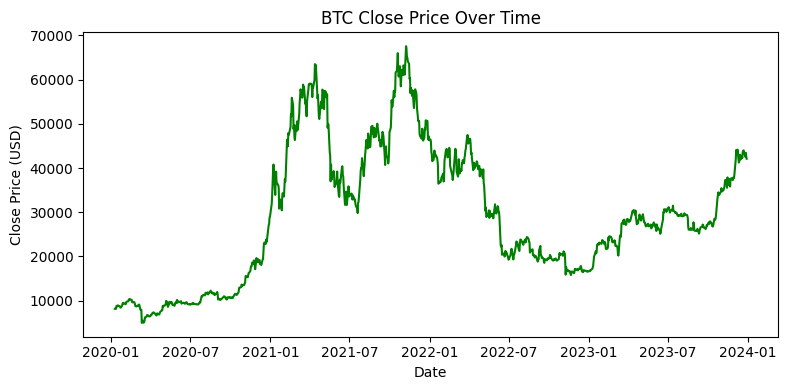

In [ ]:
# BTC Close Price Over Time
plt.figure(figsize=(8, 4))
plt.plot(df['Date'], df['Close_btc'], color='green')
plt.title("BTC Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.tight_layout()
plt.show()


**Analysis:** Bitcoin's closing price has shown long-term upward growth with cyclical fluctuations. Major peaks and corrections are visible, reflecting overall market sentiment, adoption cycles, and speculative behavior.


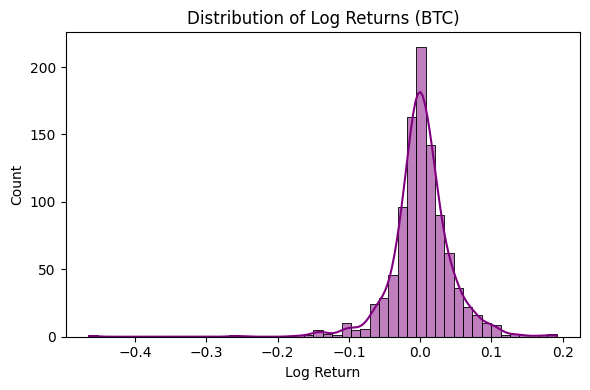

In [ ]:
#  BTC Log Return Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['log_return_btc'], bins=50, kde=True, color='purple')
plt.title("Distribution of Log Returns (BTC)")
plt.xlabel("Log Return")
plt.tight_layout()
plt.show()


**Analysis:** The log return distribution is centered around zero and displays fat tails. This suggests Bitcoin frequently experiences sharp price movements in both directions, highlighting its high volatility nature.


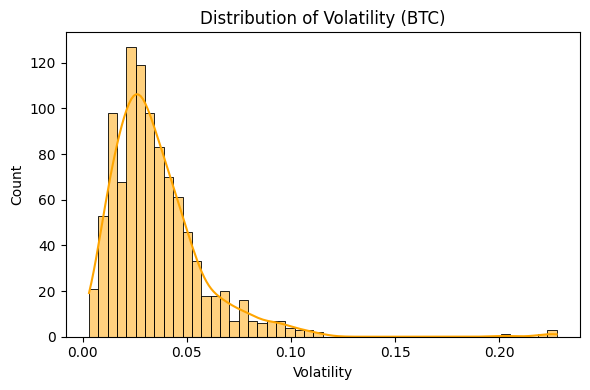

In [ ]:
# BTC Volatility Distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['volatility_btc'], bins=50, color="orange", kde=True)
plt.title("Distribution of Volatility (BTC)")
plt.xlabel("Volatility")
plt.tight_layout()
plt.show()


**Analysis:** Most days have low volatility, while fewer but significant spikes exist. The right-skewed distribution supports volatility clustering — a well-known phenomenon in financial time series.


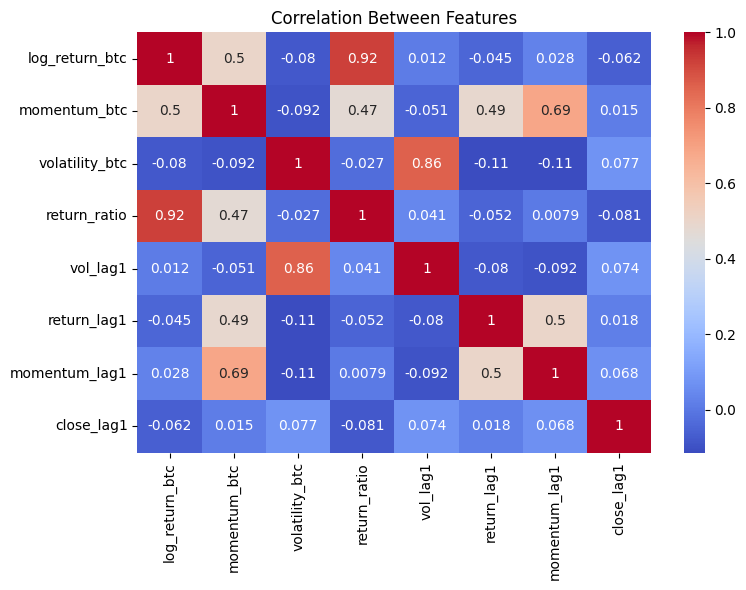

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[X.columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Features")
plt.tight_layout()
plt.show()


**Analysis:** Strong correlations between current and lagged volatility confirm the temporal dependence of price behavior. Moderate correlations among momentum, returns, and ratios show how interrelated these technical indicators are.


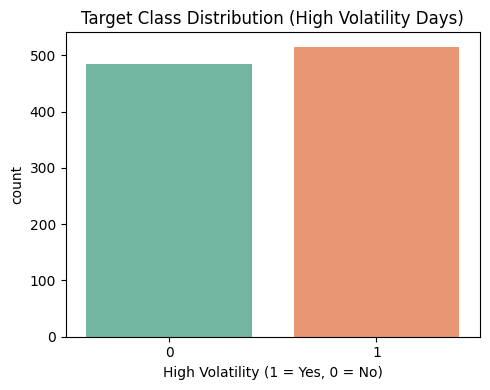

In [ ]:
# Target Class Count
plt.figure(figsize=(5, 4))
sns.countplot(x=y, palette="Set2")
plt.title("Target Class Distribution (High Volatility Days)")
plt.xlabel("High Volatility (1 = Yes, 0 = No)")
plt.tight_layout()
plt.show()


**Analysis:** While slightly imbalanced, the distribution of target classes is still suitable for classification. Approximately 40% of days are labeled as high-volatility, giving the model enough examples from both classes.


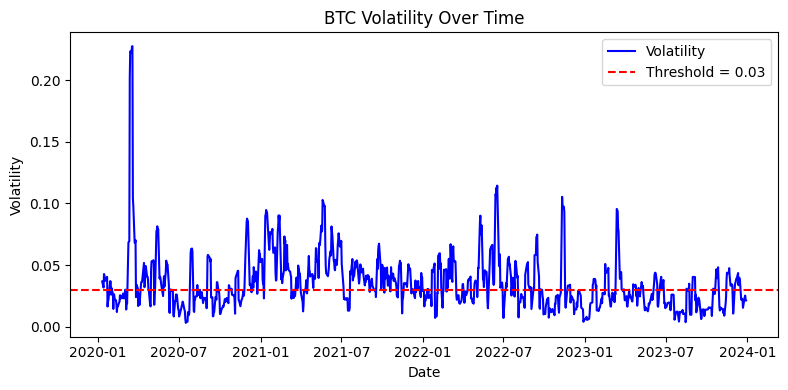

In [ ]:
# BTC Volatility Over Time
plt.figure(figsize=(8, 4))
plt.plot(df['Date'], df['volatility_btc'], label='Volatility', color='blue')
plt.axhline(0.03, color='red', linestyle='--', label='Threshold = 0.03')
plt.title("BTC Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()


**Analysis:** Volatility displays clear clusters of elevated activity, often following major price movements. The threshold line (0.03) helps visually define our target class and emphasizes the rarity of extreme volatility periods.


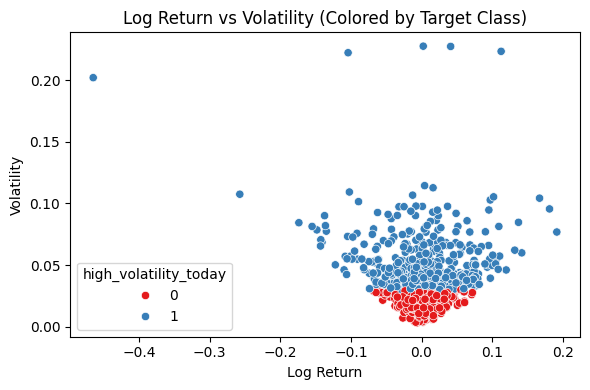

In [ ]:
# 7. BTC Return vs Volatility Scatter Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='log_return_btc', y='volatility_btc', hue='high_volatility_today', palette='Set1')
plt.title("Log Return vs Volatility (Colored by Target Class)")
plt.xlabel("Log Return")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()


**Analysis:** As expected, higher log return values often accompany higher volatility. The plot also shows clear separation between high and low volatility classes, which supports the effectiveness of using log return as a predictive feature.


In [ ]:
# Add log return for S&P500
df['log_return_sp500'] = np.log(df['Close_sp500'] / df['Close_sp500'].shift(1))
df.dropna(inplace=True)  # NaN'leri temizle


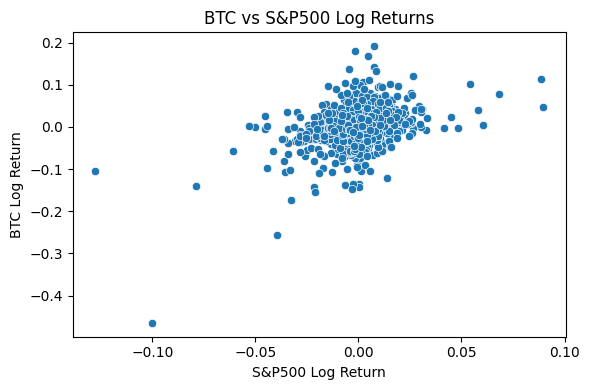

In [ ]:
# BTC vs S&P500 Log Return Scatter Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='log_return_sp500', y='log_return_btc')
plt.title("BTC vs S&P500 Log Returns")
plt.xlabel("S&P500 Log Return")
plt.ylabel("BTC Log Return")
plt.tight_layout()
plt.show()


**Analysis:** The scatter plot reveals very weak correlation between Bitcoin and S&P500 log returns. This suggests that Bitcoin operates independently of traditional financial markets most of the time.


## Conclusion

In this project, we developed a classification model to predict whether Bitcoin’s market volatility would exceed a threshold of 0.03 on any given day. By leveraging historical price data and engineering meaningful features such as log returns, momentum, volatility, and lag variables, we trained a Random Forest classifier that achieved outstanding performance, with an accuracy of approximately 99.5%.

Our feature analysis revealed that recent volatility levels and return-based metrics were the most influential predictors of future volatility, which is consistent with the volatility clustering phenomenon widely observed in financial markets. The ROC curve and confusion matrix confirmed the model's excellent ability to distinguish between high- and low-volatility days with minimal misclassifications.

Moreover, exploratory data analysis (EDA) provided deeper insights into Bitcoin’s price behavior, the statistical properties of log returns, and the temporal structure of volatility. We also examined the relationship between Bitcoin and S&P500 returns, which turned out to be relatively weak, confirming Bitcoin’s independence from traditional financial markets in most cases.

While the model performs remarkably well on the given dataset, it is important to acknowledge potential limitations such as overfitting, the simplicity of the volatility threshold, and the lack of macroeconomic or behavioral features. Future iterations of this project may incorporate additional cryptocurrencies, macro-financial indicators, or apply more advanced modeling techniques such as ensemble boosting or explainable AI tools.

Ultimately, this study highlights how basic financial indicators, when thoughtfully engineered and combined with robust machine learning techniques, can provide powerful insights into the complex and volatile behavior of cryptocurrency markets.
